In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Lambda, Dropout, LSTM, Embedding, Activation, RepeatVector, Concatenate, Dot, Bidirectional
import emoji
import csv
import pandas as pd
from tensorflow.keras.optimizers import Adam


In [98]:
def read_csvFile(filename):
    
    sentences = []
    emoji = []
    
    with open(filename, "r") as f:
        
        data = csv.reader(f)
        for row in data:
            sentences.append(row[0])
            emoji.append(row[1])
            
    sentences = np.array(sentences[1:])
    emoji = np.array(emoji[1:], dtype = int)
    
    return sentences, emoji
  
def x_to_indices(X, maxLen, word_to_indices):
    
        
    X_indices = np.zeros( (X.shape[0], maxLen) )
    word_size = len(word_to_indices)
    
    for i,x in enumerate(X):
        for j,word in enumerate(x.split()):
            
            if word.lower() in word_to_indices:
                X_indices[i, j] = word_to_indices[word.lower()]
            else:
                X_indices[i, j] = word_to_indices["unk"]
            
    return X_indices
               
def one_hot_y(Y, cls = 5):
    return np.eye(cls)[Y]


In [149]:
train_set = pd.read_csv("data/training.csv")
test_set = pd.read_csv("data/test.csv")

In [152]:
train_process = normalize_text(train_set.copy()) 
test_process = normalize_text(test_set.copy())

In [153]:
X_train = train_process.text.to_numpy()
X_test = test_process.text.to_numpy()
Y_train = train_process.label.to_numpy()
Y_test = test_process.label.to_numpy()

In [154]:
Tx = len(max(X_train, key = len).split()) + 20
Y_train_oh = one_hot_y(Y_train, 6)
Y_test_oh = one_hot_y(Y_test, 6)
cls = np.unique(Y_train).shape[0]

In [156]:
n_a = 64
n_s = 128

In [157]:
def embedding_layer(word_to_vec):
    
    word_size = len(word_to_vec)+1
    any_word = list(word_to_vec.keys())[0]
    emb_dim = word_to_vec[any_word].shape[0]
    vec_mat = np.zeros((word_size, emb_dim))
    
    i = 1
    for _,vec in word_to_vec.items():
        vec_mat[i,:] = vec
        i+=1
        
    embedding_layer = Embedding(word_size, emb_dim, trainable = False )
    embedding_layer.build((None,))
    embedding_layer.set_weights([vec_mat])
    
    return embedding_layer
    

In [158]:
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis = -1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation("softmax", name = "attention_weights")
dotor = Dot(axes = 1)
squeezor = Lambda( lambda x : tf.squeeze(x))
reshapor = Reshape((64,))

In [159]:
def attention(a):
    
    e = densor1(a)
    e = densor2(e)
    alpha = activator(e)
    context = dotor([alpha, a])
    print(tf.shape(context))
    context = reshapor(context)
    print(tf.shape(context))
    return context

In [160]:
post_LSTM = LSTM(n_s, return_state = True)
out_layer = Dense(cls, activation = "softmax")

In [161]:
def model_v2(input_shape,Tx, n_a, n_s, word_to_vec):
    
    sentence_indices = Input(shape = input_shape, dtype = "int32")
    s0 = Input(shape = (n_s,), name = "s0")
    c0 = Input(shape = (n_s,), name ="c0")
    
    s = s0
    c = c0
    
    embedding = embedding_layer(word_to_vec)
    embed = embedding(sentence_indices)
    
    a = Bidirectional(LSTM(n_a, return_sequences = True))(embed)
    a = Dropout(0.2)(a)
    a = Bidirectional(LSTM( int(n_a), return_sequences = True))(embed)
    a = Dropout(0.2)(a)
    a = Bidirectional(LSTM( int(n_a/2), return_sequences = True))(embed)
    a = Dropout(0.2)(a)
      
    context = attention(a)
    output = out_layer(context)
    
    model = Model(inputs = [sentence_indices, s0, c0], outputs = output)
    
    

    return model



In [162]:
word_to_vec, word_to_index, index_to_word = read_gloves()

In [163]:
modelV2 = model_v2( (Tx,),Tx,n_a, n_s, word_to_vec)

KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 1, 64], name='tf.compat.v1.shape_20/Shape:0', description="created by layer 'tf.compat.v1.shape_20'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 64], name='tf.compat.v1.shape_21/Shape:0', description="created by layer 'tf.compat.v1.shape_21'")


In [164]:
modelV2.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = 0.005, beta_1 = 0.9, beta_2 = 0.999), metrics = ["accuracy"])

In [165]:
X_train_indices = x_to_indices(X_train, Tx, word_to_index)
X_test_indices = x_to_indices(X_test, Tx, word_to_index)

In [148]:
Tx

53

In [166]:
s0 = np.zeros((X_train.shape[0], n_s))
c0 = np.zeros((X_train.shape[0], n_s))

In [167]:
modelV2.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 82)]         0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, 82, 300)      120000300   ['input_20[0][0]']               
                                                                                                  
 bidirectional_32 (Bidirectiona  (None, 82, 64)      85248       ['embedding_19[0][0]']           
 l)                                                                                               
                                                                                                  
 dropout_32 (Dropout)           (None, 82, 64)       0           ['bidirectional_32[0][0]']

In [36]:
modelV2.fit( X_train_indices, Y_train_oh, validation_data = ( X_test_indices, Y_test_oh), epochs = 100, batch_size =32,  )

Epoch 1/100


ValueError: in user code:

    File "C:\Users\user\miniconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\user\miniconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\miniconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\user\miniconda3\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\user\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\user\miniconda3\lib\site-packages\keras\engine\input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_1" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(32, 53) dtype=float32>]


In [168]:
modelV2.fit( (X_train_indices, s0, c0), Y_train_oh, validation_data = ( [X_test_indices, s0[:X_test.shape[0]], c0[:X_test.shape[0]]], Y_test_oh), epochs = 100, batch_size =32,  )

Epoch 1/100
500/500 [==============================] - 37s 67ms/step - loss: 1.1382 - accuracy: 0.6758 - val_loss: 0.4654 - val_accuracy: 0.8435
Epoch 2/100
500/500 [==============================] - 32s 64ms/step - loss: 0.3701 - accuracy: 0.8736 - val_loss: 0.3092 - val_accuracy: 0.8835
Epoch 3/100
500/500 [==============================] - 32s 64ms/step - loss: 0.2520 - accuracy: 0.9089 - val_loss: 0.2770 - val_accuracy: 0.8950
Epoch 4/100
500/500 [==============================] - 32s 65ms/step - loss: 0.1844 - accuracy: 0.9314 - val_loss: 0.3382 - val_accuracy: 0.8845
Epoch 5/100
500/500 [==============================] - 35s 69ms/step - loss: 0.1470 - accuracy: 0.9436 - val_loss: 0.2588 - val_accuracy: 0.9045
Epoch 6/100
500/500 [==============================] - 35s 69ms/step - loss: 0.1225 - accuracy: 0.9533 - val_loss: 0.2872 - val_accuracy: 0.8945
Epoch 7/100
273/500 [===============>..............] - ETA: 14s - loss: 0.0919 - accuracy: 0.9628

KeyboardInterrupt: 

In [170]:
train_set.label.value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In [177]:
testing = np.array(["I am feeling good"])
testing = x_to_indices(testing, Tx, word_to_index)
modelV2.predict([testing])

ValueError: in user code:

    File "C:\Users\user\miniconda3\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\user\miniconda3\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\miniconda3\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\user\miniconda3\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\Users\user\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\user\miniconda3\lib\site-packages\keras\engine\input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_10" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 82) dtype=float32>]


In [82]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

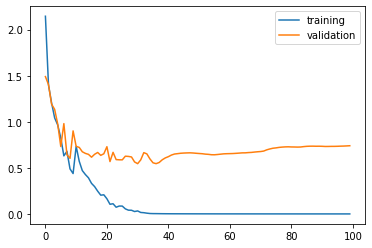

In [83]:
plt.figure()
plt.plot(history.history["loss"], label = "training")
plt.plot(history.history["val_loss"],label = "validation")
plt.legend()

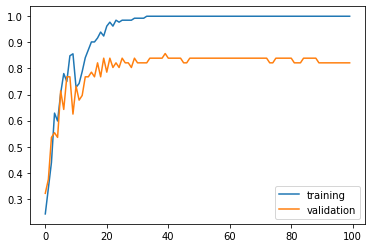

In [84]:
plt.figure()
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"],label = "validation")
plt.legend()